# Trainable ResNet-based CT–MRI Fusion (No Ground Truth)

This notebook implements a ResNet-based feature fusion approach for CT and MRI images, using pretrained ResNet for feature extraction and learning fusion in the feature space.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dataclasses import dataclass
from typing import Tuple
import os
import glob
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [17]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [18]:
# Dataset class for paired medical images
class PairedMedicalFusionDataset(Dataset):
    """Paired dataset for registered CT & MRI images.
    - root_ct, root_mri: directories with identical filenames
    - resize: (H,W) or None
    - file_exts: accepted extensions
    """
    def __init__(self, root_ct: str, root_mri: str, resize: Tuple[int,int]=None,
                 file_exts=(".png",".jpg",".jpeg",".bmp",".tif",".tiff")):
        self.root_ct = root_ct
        self.root_mri = root_mri
        self.resize = resize

        def index_dir(root):
            paths = []
            for ext in file_exts:
                paths.extend(glob.glob(os.path.join(root, f"**/*{ext}"), recursive=True))
            base = {os.path.splitext(os.path.relpath(p, root))[0].replace('\\','/') : p for p in paths}
            return base

        base_ct = index_dir(root_ct)
        base_mr = index_dir(root_mri)
        self.keys = sorted(list(set(base_ct.keys()) & set(base_mr.keys())))
        if not self.keys:
            raise RuntimeError("No paired files found. Ensure matching filenames between CT and MRI.")
        self.base_ct = base_ct
        self.base_mr = base_mr

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx: int):
        key = self.keys[idx]
        p_ct = self.base_ct[key]
        p_mr = self.base_mr[key]

        ct = cv2.imread(p_ct, cv2.IMREAD_GRAYSCALE)
        mr = cv2.imread(p_mr, cv2.IMREAD_GRAYSCALE)
        if ct is None or mr is None:
            raise FileNotFoundError(p_ct if ct is None else p_mr)
        if self.resize is not None:
            H, W = self.resize
            ct = cv2.resize(ct, (W, H), interpolation=cv2.INTER_AREA)
            mr = cv2.resize(mr, (W, H), interpolation=cv2.INTER_AREA)

        ct = ct.astype(np.float32)
        mr = mr.astype(np.float32)
        if ct.max() > 1.0: ct /= 255.0
        if mr.max() > 1.0: mr /= 255.0

        ct_t = torch.from_numpy(ct)[None, ...]   # (1,H,W)
        mr_t = torch.from_numpy(mr)[None, ...]
        return ct_t, mr_t, key

In [19]:
# Loss components
class SSIM(nn.Module):
    def __init__(self, window_size=11, C1=0.01**2, C2=0.03**2):
        super().__init__()
        self.window_size = window_size
        self.C1 = C1
        self.C2 = C2
        gauss = cv2.getGaussianKernel(window_size, window_size/6)
        gauss = gauss @ gauss.T
        w = torch.from_numpy(gauss.astype(np.float32))[None, None]
        self.register_buffer('window', w)

    def _filt(self, x):
        pad = self.window_size//2
        window = self.window.to(x.device)
        return F.conv2d(x, window, padding=pad, groups=x.size(1))

    def forward(self, x, y):
        # x,y: (B,1,H,W) in [0,1]
        mu_x = self._filt(x)
        mu_y = self._filt(y)
        mu_x2, mu_y2, mu_xy = mu_x*mu_x, mu_y*mu_y, mu_x*mu_y
        sigma_x2 = self._filt(x*x) - mu_x2
        sigma_y2 = self._filt(y*y) - mu_y2
        sigma_xy = self._filt(x*y) - mu_xy
        ssim = ((2*mu_xy + self.C1)*(2*sigma_xy + self.C2)) / ((mu_x2 + mu_y2 + self.C1)*(sigma_x2 + sigma_y2 + self.C2) + 1e-8)
        return ssim.mean()

class GradientLoss(nn.Module):
    def __init__(self):
        super().__init__()
        kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=np.float32)
        ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=np.float32)
        self.register_buffer('kx', torch.from_numpy(kx)[None, None])
        self.register_buffer('ky', torch.from_numpy(ky)[None, None])

    def forward(self, fused, ct, mr):
        def grad(img):
            gx = F.conv2d(img, self.kx, padding=1)
            gy = F.conv2d(img, self.ky, padding=1)
            return torch.sqrt(gx*gx + gy*gy + 1e-8)
        gF = grad(fused)
        gC = grad(ct)
        gM = grad(mr)
        gT = torch.max(gC, gM)
        return F.l1_loss(gF, gT)

class VGGPerceptual(nn.Module):
    def __init__(self, device):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.slice1 = nn.Sequential(*[vgg[i] for i in range(4)])   # relu1_2
        self.slice2 = nn.Sequential(*[vgg[i] for i in range(4,9)]) # relu2_2
        for p in self.parameters():
            p.requires_grad = False
        self.to(device)

    def forward(self, x):
        # Ensure input is single-channel by averaging across channels if needed,
        # then convert to 3-channel RGB and apply ImageNet normalization.
        if x.size(1) != 1:
            x_gray = x.mean(dim=1, keepdim=True)
        else:
            x_gray = x
        x3 = x_gray.repeat(1, 3, 1, 1)
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device)[None,:,None,None]
        std  = torch.tensor([0.229, 0.224, 0.225], device=x.device)[None,:,None,None]
        x3 = (x3 - mean) / std
        f1 = self.slice1(x3)
        f2 = self.slice2(f1)
        return f1, f2

def perceptual_loss(vgg: VGGPerceptual, fused, ct, mr):
    fF1, fF2 = vgg(fused)
    cF1, cF2 = vgg(ct)
    mF1, mF2 = vgg(mr)
    return 0.5*(F.l1_loss(fF1, cF1) + F.l1_loss(fF1, mF1) + F.l1_loss(fF2, cF2) + F.l1_loss(fF2, mF2))

class FusionLoss(nn.Module):
    def __init__(self, device, w_ssim=1.0, w_grad=1.0, w_perc=0.1):
        super().__init__()
        self.ssim = SSIM()
        self.grad = GradientLoss()
        self.vgg = VGGPerceptual(device)
        self.w_ssim = w_ssim
        self.w_grad = w_grad
        self.w_perc = w_perc
    def forward(self, fused, ct, mr):
        l_ssim = 0.5*(1.0 - self.ssim(fused, ct)) + 0.5*(1.0 - self.ssim(fused, mr))
        l_grad = self.grad(fused, ct, mr)
        l_perc = perceptual_loss(self.vgg, fused, ct, mr)
        total = self.w_ssim*l_ssim + self.w_grad*l_grad + self.w_perc*l_perc
        return total, {"ssim": l_ssim.item(), "grad": l_grad.item(), "perc": l_perc.item()}

In [20]:
# ResNet-based Fusion Network
class ResNetFusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.fusion1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.fusion2 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.fusion3 = nn.Sequential(
            nn.Conv2d(2048, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def extract_features(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        f1 = self.layer1(x)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        return f1, f2, f3

    def forward(self, ct, mr):
        ct_f1, ct_f2, ct_f3 = self.extract_features(ct)
        mr_f1, mr_f2, mr_f3 = self.extract_features(mr)
        fused_f1 = self.fusion1(torch.cat([ct_f1, mr_f1], dim=1))
        fused_f2 = self.fusion2(torch.cat([ct_f2, mr_f2], dim=1))
        fused_f3 = self.fusion3(torch.cat([ct_f3, mr_f3], dim=1))
        x = self.up3(fused_f3)
        x = torch.cat([x, fused_f2], dim=1)
        x = self.up2(x)
        x = torch.cat([x, fused_f1], dim=1)
        x = self.up1(x)
        x = self.final(x)
        return x

In [21]:
# Config class
@dataclass
class Config:
    ct_dir: str = '../Dataset/CT-MRI/CT'
    mri_dir: str = '../Dataset/CT-MRI/MRI'
    save_dir: str = 'results/resnet_fusion'
    intermediate_dir: str = 'checkpoints/intermediate/resnet_fusion'
    final_dir: str = 'checkpoints/final/resnet_fusion'
    resize: Tuple[int,int] = (256, 256)
    batch_size: int = 4
    epochs: int = 10
    lr: float = 2e-4
    val_split: float = 0.1
    w_ssim: float = 1.0
    w_grad: float = 0.5
    w_perc: float = 0.1
    save_every: int = 5  # Save checkpoint every N epochs

# Example: Config(ct_dir='../Dataset/CT-MRI/CT', mri_dir='../Dataset/CT-MRI/MRI', save_dir='results/resnet_fusion', resize=(256, 256), batch_size=4, epochs=100, lr=0.0002, val_split=0.1, w_ssim=1.0, w_grad=0.5, w_perc=0.1)

In [22]:
# Training setup
cfg = Config()
print(cfg)
model = ResNetFusionNet().to(device)
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.bn1.parameters():
    param.requires_grad = False
for param in model.layer1.parameters():
    param.requires_grad = False
loss_fn = FusionLoss(device, w_ssim=cfg.w_ssim, w_grad=cfg.w_grad, w_perc=cfg.w_perc).to(device)
dataset = PairedMedicalFusionDataset(cfg.ct_dir, cfg.mri_dir, resize=cfg.resize)
train_size = int((1 - cfg.val_split) * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False, num_workers=2)
print(f"Dataset size: {len(dataset)}, Train: {len(train_set)}, Val: {len(val_set)}")
opt = torch.optim.Adam([
    {'params': model.layer2.parameters(), 'lr': cfg.lr * 0.1},
    {'params': model.layer3.parameters(), 'lr': cfg.lr * 0.1},
    {'params': model.fusion1.parameters(), 'lr': cfg.lr},
    {'params': model.fusion2.parameters(), 'lr': cfg.lr},
    {'params': model.fusion3.parameters(), 'lr': cfg.lr},
    {'params': model.up3.parameters(), 'lr': cfg.lr},
    {'params': model.up2.parameters(), 'lr': cfg.lr},
    {'params': model.up1.parameters(), 'lr': cfg.lr},
    {'params': model.final.parameters(), 'lr': cfg.lr}
], lr=cfg.lr)
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5, verbose=True)
os.makedirs(cfg.save_dir, exist_ok=True)
os.makedirs(cfg.intermediate_dir, exist_ok=True)
os.makedirs(cfg.final_dir, exist_ok=True)

Config(ct_dir='../Dataset/CT-MRI/CT', mri_dir='../Dataset/CT-MRI/MRI', save_dir='results/resnet_fusion', intermediate_dir='checkpoints/intermediate/resnet_fusion', final_dir='checkpoints/final/resnet_fusion', resize=(256, 256), batch_size=4, epochs=10, lr=0.0002, val_split=0.1, w_ssim=1.0, w_grad=0.5, w_perc=0.1, save_every=5)
Dataset size: 573, Train: 515, Val: 58
Dataset size: 573, Train: 515, Val: 58


In [23]:
# Training loop
best_val = float('inf')
for epoch in range(1, cfg.epochs+1):
    model.train()
    tr_running = 0.0
    for ct, mr, _ in train_loader:
        ct = ct.to(device)
        mr = mr.to(device)
        fused = model(ct, mr)
        loss, parts = loss_fn(fused, ct, mr)
        opt.zero_grad()
        loss.backward()
        opt.step()
        tr_running += loss.item() * ct.size(0)
    tr_loss = tr_running / len(train_set)
    model.eval()
    va_running = 0.0
    with torch.no_grad():
        for ct, mr, _ in val_loader:
            ct = ct.to(device)
            mr = mr.to(device)
            fused = model(ct, mr)
            loss, parts = loss_fn(fused, ct, mr)
            va_running += loss.item() * ct.size(0)
    va_loss = va_running / len(val_set)
    scheduler.step(va_loss)
    print(f"Epoch {epoch:03d} | train {tr_loss:.4f} | val {va_loss:.4f}")

    # Save intermediate checkpoint every N epochs
    if epoch % cfg.save_every == 0:
        intermediate_path = os.path.join(cfg.intermediate_dir, f'resnet_fusion_epoch_{epoch:03d}.pt')
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'opt': opt.state_dict(),
            'scheduler': scheduler.state_dict(),
            'train_loss': tr_loss,
            'val_loss': va_loss,
            'cfg': cfg.__dict__
        }, intermediate_path)
        print(f'Intermediate checkpoint saved: {intermediate_path}')

    # Save best model to final directory
    if va_loss < best_val:
        best_val = va_loss
        final_path = os.path.join(cfg.final_dir, 'resnet_fusion_best.pt')
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'opt': opt.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_val_loss': best_val,
            'cfg': cfg.__dict__
        }, final_path)
        print(f'Best model saved: {final_path}')

Epoch 001 | train 0.8871 | val 0.5821
Best model saved: checkpoints/final/resnet_fusion/resnet_fusion_best.pt
Best model saved: checkpoints/final/resnet_fusion/resnet_fusion_best.pt
Epoch 002 | train 0.5591 | val 0.5666
Epoch 002 | train 0.5591 | val 0.5666
Best model saved: checkpoints/final/resnet_fusion/resnet_fusion_best.pt
Best model saved: checkpoints/final/resnet_fusion/resnet_fusion_best.pt
Epoch 003 | train 0.5406 | val 0.5589
Epoch 003 | train 0.5406 | val 0.5589
Best model saved: checkpoints/final/resnet_fusion/resnet_fusion_best.pt
Best model saved: checkpoints/final/resnet_fusion/resnet_fusion_best.pt
Epoch 004 | train 0.5314 | val 0.5758
Epoch 004 | train 0.5314 | val 0.5758
Epoch 005 | train 0.5237 | val 0.5591
Epoch 005 | train 0.5237 | val 0.5591
Intermediate checkpoint saved: checkpoints/intermediate/resnet_fusion/resnet_fusion_epoch_005.pt
Intermediate checkpoint saved: checkpoints/intermediate/resnet_fusion/resnet_fusion_epoch_005.pt
Epoch 006 | train 0.5185 | val 0

In [24]:
# Inference function
def fuse_with_resnet(ct_path, mr_path, model, device, resize=None):
    ct = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)
    mr = cv2.imread(mr_path, cv2.IMREAD_GRAYSCALE)
    if resize is not None:
        ct = cv2.resize(ct, resize, interpolation=cv2.INTER_AREA)
        mr = cv2.resize(mr, resize, interpolation=cv2.INTER_AREA)
    ct = ct.astype(np.float32) / 255.0
    mr = mr.astype(np.float32) / 255.0
    ct_t = torch.from_numpy(ct)[None, None, ...].to(device)
    mr_t = torch.from_numpy(mr)[None, None, ...].to(device)
    with torch.no_grad():
        fused = model(ct_t, mr_t)
    return fused.squeeze().cpu().numpy()

Loaded best model from: checkpoints/final/resnet_fusion/resnet_fusion_best.pt
Using example pair: ../Dataset/CT-MRI/CT/16003.png and ../Dataset/CT-MRI/MRI/16003.png


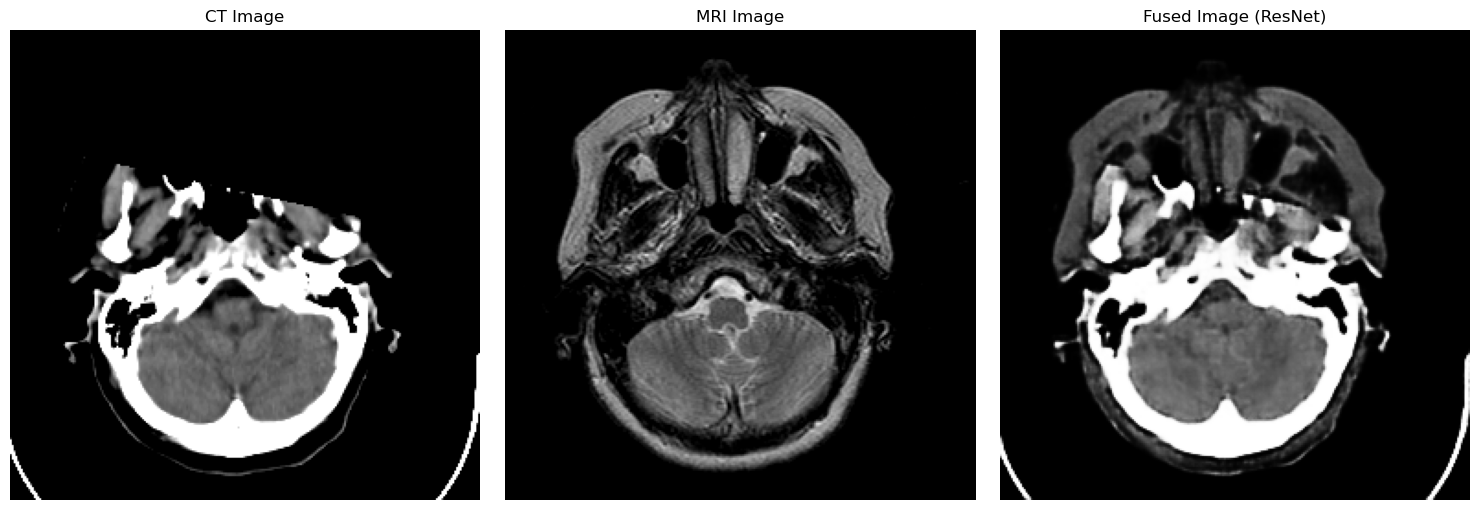

Fusion example saved to results/resnet_fusion/fusion_example.png


In [25]:
# Example usage
best_model = ResNetFusionNet().to(device)
checkpoint_path = os.path.join(cfg.final_dir, 'resnet_fusion_best.pt')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    best_model.load_state_dict(checkpoint['model'])
    print(f'Loaded best model from: {checkpoint_path}')
else:
    print(f'Warning: Best model not found at {checkpoint_path}. Using untrained model.')
best_model.eval()
best_model.eval()
sample_ct_files = glob.glob(os.path.join(cfg.ct_dir, '*.png'))
sample_mri_files = glob.glob(os.path.join(cfg.mri_dir, '*.png'))
if sample_ct_files and sample_mri_files:
    ct_example = sample_ct_files[0]
    ct_basename = os.path.splitext(os.path.basename(ct_example))[0]
    mr_example = os.path.join(cfg.mri_dir, f'{ct_basename}.png')
    if os.path.exists(mr_example):
        print(f'Using example pair: {ct_example} and {mr_example}')
        fused_image = fuse_with_resnet(ct_example, mr_example, best_model, device, cfg.resize)
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        ct_img = cv2.imread(ct_example, cv2.IMREAD_GRAYSCALE)
        plt.imshow(ct_img, cmap='gray')
        plt.title('CT Image')
        plt.axis('off')
        plt.subplot(132)
        mr_img = cv2.imread(mr_example, cv2.IMREAD_GRAYSCALE)
        plt.imshow(mr_img, cmap='gray')
        plt.title('MRI Image')
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(fused_image, cmap='gray')
        plt.title('Fused Image (ResNet)')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(cfg.save_dir, 'fusion_example.png'), dpi=150, bbox_inches='tight')
        plt.show()
        print(f'Fusion example saved to {cfg.save_dir}/fusion_example.png')
    else:
        print(f'No matching MRI file found for {ct_example}')
else:
    print('No sample images found in the dataset directories')